<center><h1>The profitability factor</h1></center

<center>William Mann</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Emory_small.png" height="200px" width="300px" />
</center>

This notebook will illustrate how the Fama-French 3-factor model can be used to evaluate new investment ideas. Specifically, we will think about a style called *profitability*.
The idea is to invest more in stocks that have higher profitability.

The notebook will compare two different ratios you might use to implement that idea:

1. The first is the ratio of cash flow to price.
2. The second is the ratio of operating profitability book assets.

In both cases, the numerator is a measure of cash flow or profits, and the denominator is a scaling factor.
It turns out that the difference in the numerator is not very important.
(I would use the same numerator in each if I could, but the data are not easily available.)
On the other hand, the choice of denominator makes a big difference, even though it's just meant to be a scaling factor.

More specifically, for each ratio we will look at the spread of returns of stocks with high or low values of the ratios. We will think of that spread as telling us about the returns of a corresponding investment strategy, and we will evaluate the spread using the Fama-French 3-factor model. This model will reveal that a strategy based on ratio #1 is economically no different from investing in a simple value strategy. On the other hand, a strategy based on ratio #2 will indeed represent something new. This second ratio is the basis for the well-known "profitability" strategy that is widely implemented today.

The basic reason for the different results using the two different ratios, is that *any* strategy based on a price ratio will tend to steer you towards the same set of value stocks. Prices move around so much that nothing else can really come through in the data. In this case, portfolios formed on cash flow to price are very similar to our typical value portfolios, which are based on book value to price. When we switch the denominator to something more stable, there is at least the opportunity for this strategy to look different.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import wrds
import math
import numpy
import statsmodels.formula.api as sm
import wget, shutil
import os

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16.0, 8.0]

# Connect to WRDS
conn = wrds.Connection(wrds_username='wmann')

# Fama-French factor returns
FF3F = conn.get_table(library='ff_all',table='fivefactors_monthly')
# for some reason get_table has started returning the Fama-French data with dtype '0', so convert to float:
for key,col in FF3F.items():
    if key == 'date' or key == 'dateff': continue
    FF3F[key] = FF3F[key].astype('float64')
FF3F['month'] = pd.to_datetime(FF3F['date']).dt.to_period('M')
FF3F = FF3F.drop('date',axis=1).set_index('month')
FF3F = FF3F['1964':'2023']

# Download Ken French portfolios based on cash flow to price
try: os.remove('Portfolios_Formed_on_CF-P_CSV.zip')
except OSError: pass
try: os.remove('Portfolios_Formed_on_CF-P.CSV')
except OSError: pass
wget.download('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Portfolios_Formed_on_CF-P_CSV.zip','Portfolios_Formed_on_CF-P_CSV.zip')
shutil.unpack_archive('Portfolios_Formed_on_CF-P_CSV.zip')

# Read the CSV file and build the data
portfolios_CF = pd.read_csv('Portfolios_Formed_on_CF-P.CSV',skiprows=18,nrows=875,encoding="ISO-8859-1")
portfolios_CF.columns = ['date','negative','l030','med40','hi30','q1','q2','q3','q4','q5','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
portfolios_CF['month'] = pd.to_datetime(portfolios_CF['date'], format='%Y%m').dt.to_period('M')
portfolios_CF = portfolios_CF[['month']+['d'+str(i) for i in range(1,11)]].set_index('month')
portfolios_CF = portfolios_CF/100
portfolios_CF = portfolios_CF['1964':'2023']

# Download Ken French portfolios based on operating profitability
try: os.remove('Portfolios_Formed_on_OP_CSV.zip')
except OSError: pass
try: os.remove('Portfolios_Formed_on_OP.CSV')
except OSError: pass
wget.download('https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Portfolios_Formed_on_OP_CSV.zip','Portfolios_Formed_on_OP_CSV.zip')
shutil.unpack_archive('Portfolios_Formed_on_OP_CSV.zip')
portfolios_OP = pd.read_csv('Portfolios_Formed_on_OP.CSV',skiprows=24,nrows=731,encoding="ISO-8859-1")
portfolios_OP.columns = ['date','l030','med40','hi30','q1','q2','q3','q4','q5','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10']
portfolios_OP['month'] = pd.to_datetime(portfolios_OP['date'], format='%Y%m').dt.to_period('M')
portfolios_OP = portfolios_OP[['month']+['d'+str(i) for i in range(1,11)]].set_index('month')
portfolios_OP = portfolios_OP/100
portfolios_OP = portfolios_OP['1964':'2023']

Loading library list...
Done
100% [........................................................] 130377 / 130377

### Analysis of portfolios sorted on cash flow to price

In [2]:
%%capture

portfolios_CF_excess = {'d'+str(i): portfolios_CF['d'+str(i)] - FF3F['rf'] for i in range(1,11)}
for factor in ('mktrf','smb','hml'):
    portfolios_CF_excess[factor] = FF3F[factor]

actual_returns = [portfolios_CF_excess['d'+str(i)].mean() for i in range(1,11)]

# Figure summarizing CAPM analysis:
# Get predicted returns
predicted_returns = [ sm.ols("d"+str(i)+"~mktrf",data=portfolios_CF_excess).fit().params[1]*portfolios_CF_excess['mktrf'].mean() for i in range(1,11)]
# Generate new figure
CF_CAPM_figure,ax = plt.subplots()
# Scatter plot returns
plt.scatter(predicted_returns,actual_returns)
# Add 45-degree line
ax.axline([0,0],[1,1],color='orange')
# Set axis ranges
ax.set_xlim([0,0.01])
ax.set_ylim([0,0.01])

# Fama-French three-factor analysis:
# Get predicted returns
factor_averages = [portfolios_CF_excess[factor].mean() for factor in ('mktrf','smb','hml')]
predicted_returns = [ sm.ols("d"+str(i)+"~mktrf+smb+hml",data=portfolios_CF_excess).fit().params[1:4] @ factor_averages for i in range(1,11)]
# Generate new figure
CF_FF3F_figure,ax = plt.subplots()
# Scatter plot returns
plt.scatter(predicted_returns,actual_returns)
# Add 45-degree line
ax.axline([0,0],[1,1],color='orange')
# Set axis ranges
ax.set_xlim([0,0.01])
ax.set_ylim([0,0.01])

### Analysis of portfolios sorted on cash flow to price, using the CAPM

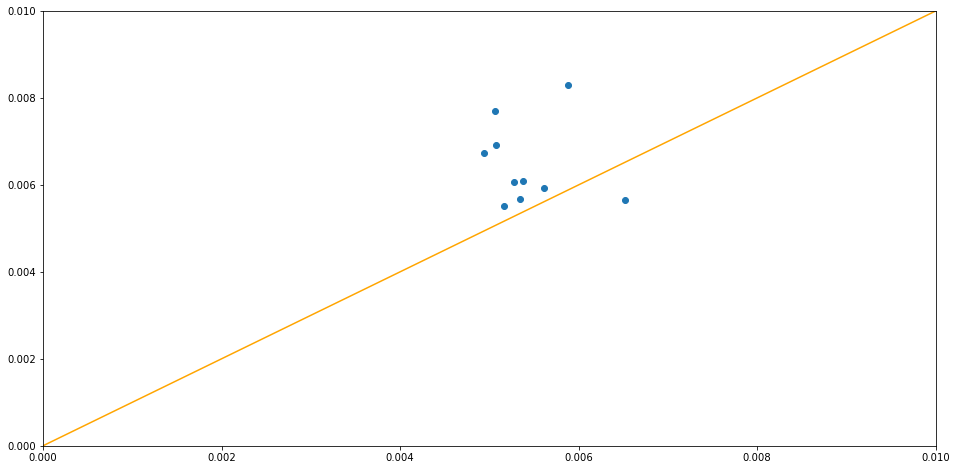

In [3]:
CF_CAPM_figure

### Analysis of portfolios sorted on cash flow to price, using the Fama-French 3-factor model

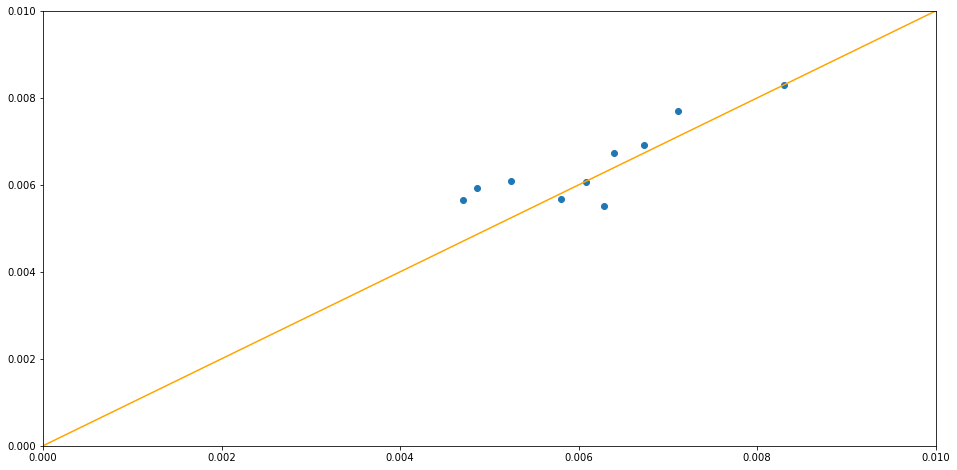

In [4]:
CF_FF3F_figure

### Analysis of portfolios sorted on cash flow to price: Takeaways

This strategy beats the CAPM, but that performance is completely explained by its three-factor loadings.

This is not surprising: We sorted on cash flow to *price*, and trading based on any ratio involving price is going to look like trading HML, because the price is so much more volatile than any other financial variable.

The conclusion is not necessarily that this is a "bad" strategy, but that there is no reason to think of it as anything new: We already know that value stocks outperformed growth stocks during the historical time period that we are using for this analysis, and (to a lesser extent) small-cap stocks outperformed large-cap stocks. The analysis here tells us that the idea of buying stocks with high CF/P ratio steers us towards those same strategies, and generates returns that are basically in line with what we would have expected based on that fact.

### Analysis of portfolios sorted on operating profitability

In [5]:
%%capture

portfolios_OP_excess = {'d'+str(i): portfolios_OP['d'+str(i)] - FF3F['rf'] for i in range(1,11)}
for factor in ('mktrf','smb','hml'):
    portfolios_OP_excess[factor] = FF3F[factor]

actual_returns = [portfolios_OP_excess['d'+str(i)].mean() for i in range(1,11)]

# Figure summarizing CAPM analysis:
# Get predicted returns
predicted_returns = [ sm.ols("d"+str(i)+"~mktrf",data=portfolios_OP_excess).fit().params[1]*portfolios_OP_excess['mktrf'].mean() for i in range(1,11)]
# Generate new figure
OP_CAPM_figure,ax = plt.subplots()
# Scatter plot returns
plt.scatter(predicted_returns,actual_returns)
# Add 45-degree line
ax.axline([0,0],[1,1],color='orange')
# Set axis ranges
ax.set_xlim([0,0.01])
ax.set_ylim([0,0.01])

# Fama-French three-factor analysis:
# Get predicted returns
factor_averages = [portfolios_OP_excess[factor].mean() for factor in ('mktrf','smb','hml')]
predicted_returns = [ sm.ols("d"+str(i)+"~mktrf+smb+hml",data=portfolios_OP_excess).fit().params[1:4] @ factor_averages for i in range(1,11)]
# Generate new figure
OP_FF3F_figure,ax = plt.subplots()
# Scatter plot returns
plt.scatter(predicted_returns,actual_returns)
# Add 45-degree line
ax.axline([0,0],[1,1],color='orange')
# Set axis ranges
ax.set_xlim([0,0.01])
ax.set_ylim([0,0.01])

### Analysis of portfolios sorted on operating profitability, using the CAPM

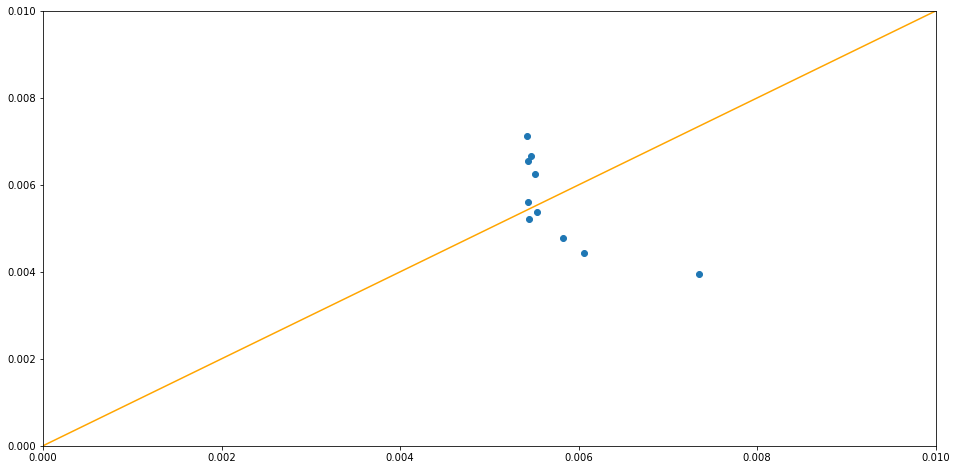

In [6]:
OP_CAPM_figure

### Analysis of portfolios sorted on operating profitability, using the Fama-French three-factor model

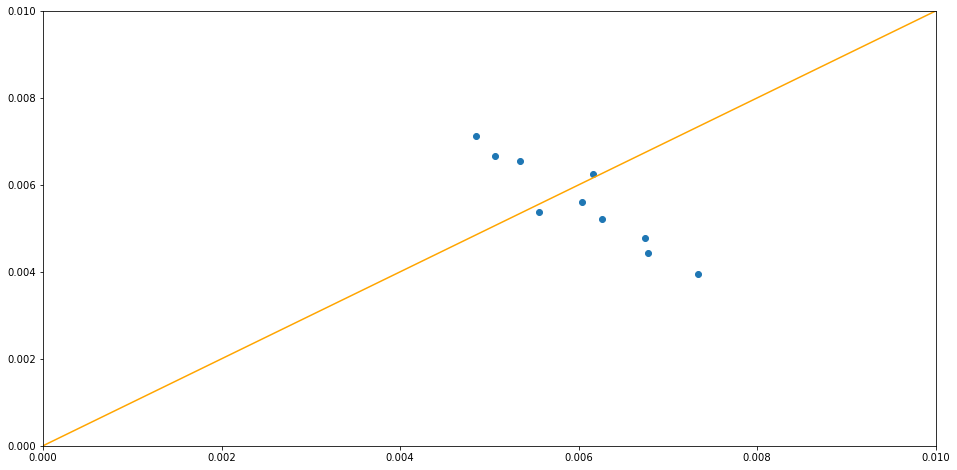

In [7]:
OP_FF3F_figure

### Analysis of portfolios sorted on operating profitability: Takeaways

Here we are sorting on operating profitability scaled by book assets. The numerator is not all that different from cash flow, which is what we used in the prior section. The main difference is the use of book assets instead of market value in the denominator. Because book assets are more stable, this avoids the situation we ran into before, where the market value dominates everything else in the sorting approach due to its high volatility and causes the strategy to just look like HML. 

The portfolios plotted here are used to calculate the well-known "profitability" factor.

In [8]:
# Uncomment this block to save this data to Excel spreadsheet to reproduce the results in class:

# try: os.remove("Profitability.xlsx")
# except OSError: pass

# # set up custom ExcelWriter engine to get the date format correct in the output file
# writer = pd.ExcelWriter('Profitability.xlsx', engine='xlsxwriter', datetime_format= "yyyy-mm")

# FF3F.to_excel(writer,sheet_name='Fama-French factors',index_label='Month',
#                   columns=['rf','mktrf','smb','hml'],
#                   header=['Risk-free return','Market excess return','SMB return','HML return'])

# portfolios_CF.to_excel(writer,sheet_name='Cash flow to price',index_label='Month',
#                    columns=['d'+str(i) for i in range(1,11)],
#                    header=['Portfolio 1: Stocks with lowest CF/P ratios']
#                        + ['Portfolio '+str(i) for i in range(2,10)]
#                        + ['Portfolio 10: Stocks with highest CF/P ratios'])

# portfolios_OP.to_excel(writer,sheet_name='Operating profitability',index_label='Month',
#                    columns=['d'+str(i) for i in range(1,11)],
#                    header=['Portfolio 1: Stocks with lowest operating profitability']
#                        + ['Portfolio '+str(i) for i in range(2,10)]
#                        + ['Portfolio 10: Stocks with highest operating profitability'])

# writer.close()

### Performance of profitability compared with other Fama-French factors

The rest of this document does a quick comparison of the Fama-French implementation of the five factors that we have discussed so far:

- The market excess return
- SMB (small-cap minus big-cap stocks)
- HML (value stocks minus growth stocks)
- UMD (high-momentum minus low-momentum stocks)
- RMW (high-profitability minus low-profitability stocks)

Average monthly % returns on each factor:  
"MKTRF" represents the excess return on the value-weighted market portfolio.  
The others are the factor returns as defined in the class notes.

In [9]:
for factor in ('mktrf','smb','hml','umd','rmw'):
    print(f"{factor.upper()}: {100*FF3F[factor].mean():.2f}%")

MKTRF: 0.56%
SMB: 0.22%
HML: 0.29%
UMD: 0.60%
RMW: 0.28%


Loading of profitability on market, SMB, HML, UMD:

In [10]:
sm.ols( "rmw ~ mktrf + smb + hml",data=FF3F).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0035,0.001,4.396,0.000,0.002,0.005
mktrf,-0.0404,0.018,-2.203,0.028,-0.076,-0.004
smb,-0.2432,0.027,-9.154,0.000,-0.295,-0.191
hml,0.0478,0.026,1.814,0.070,-0.004,0.100


Cumulative return on all five factors since 1975:

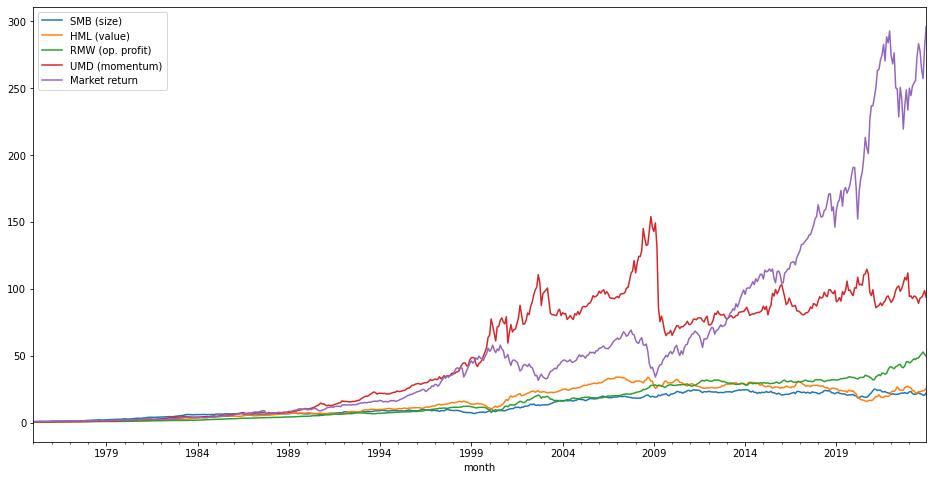

In [11]:
FF3Fb = FF3F['1975':'2023']
(1+FF3Fb['rf']+FF3Fb['smb']).cumprod().plot(legend=True,label="SMB (size)");
(1+FF3Fb['rf']+FF3Fb['hml']).cumprod().plot(legend=True,label="HML (value)");
(1+FF3Fb['rf']+FF3Fb['rmw']).cumprod().plot(legend=True,label="RMW (op. profit)");
(1+FF3Fb['rf']+FF3Fb['umd']).cumprod().plot(legend=True,label="UMD (momentum)");
(1+FF3Fb['rf']+FF3Fb['mktrf']).cumprod().plot(legend=True,label="Market return");

Takeaways from the previous figure:

The figure is dominated by the market return. This makes sense given the much larger monthly return that we calculated for MKTRF compared to the others. However, it is a bit "apples to oranges" to plot this "factor" alongside the others: By definition it has a beta of 1 and all the others have beta of zero. A risk-averse investor should *expect* a higher return from the market than any of the others. The point of constructing the other zero-beta factors is to find something that is valuable to hold alongside the market. So, let's redo the figure without the market return.

Cumulative return on just the zero-beta factors since 1975, minus the cumulative risk-free return:

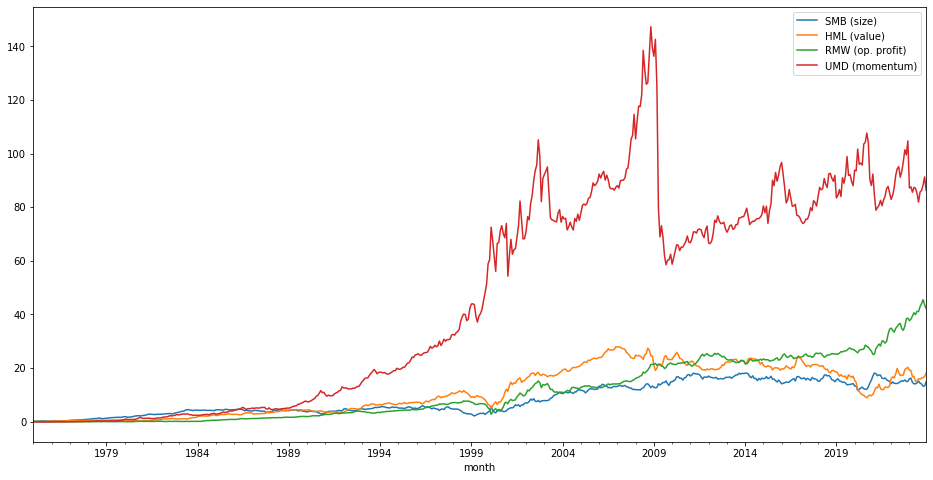

In [12]:
FF3Fb = FF3F['1975':'2023']
((1+FF3Fb['rf']+FF3Fb['smb']).cumprod() - (1+FF3Fb['rf']).cumprod()).plot(legend=True,label="SMB (size)");
((1+FF3Fb['rf']+FF3Fb['hml']).cumprod() - (1+FF3Fb['rf']).cumprod()).plot(legend=True,label="HML (value)");
((1+FF3Fb['rf']+FF3Fb['rmw']).cumprod() - (1+FF3Fb['rf']).cumprod()).plot(legend=True,label="RMW (op. profit)");
((1+FF3Fb['rf']+FF3Fb['umd']).cumprod() - (1+FF3Fb['rf']).cumprod()).plot(legend=True,label="UMD (momentum)");

Takeaways from the previous figure:

Now the figure is dominated by UMD. Momentum has delivered astonishing performance over this long time period. However, we can also see that this is mainly driven by its performance leading up to the global financial crisis. At that point momentum experienced a spectacular crash, and since then it has delivered positive returns but not on the same level as the others.

We also have to be careful in general comparing UMD with the others, since it assumes monthly rebalancing of portfolios while the others are annual, and the strategy is inherently high turnover. This makes it a bigger issue that we are ignoring transaction costs. However, this issue is unlikely to greatly change the results of this figure.

Let's redo the previous figure without momentum:

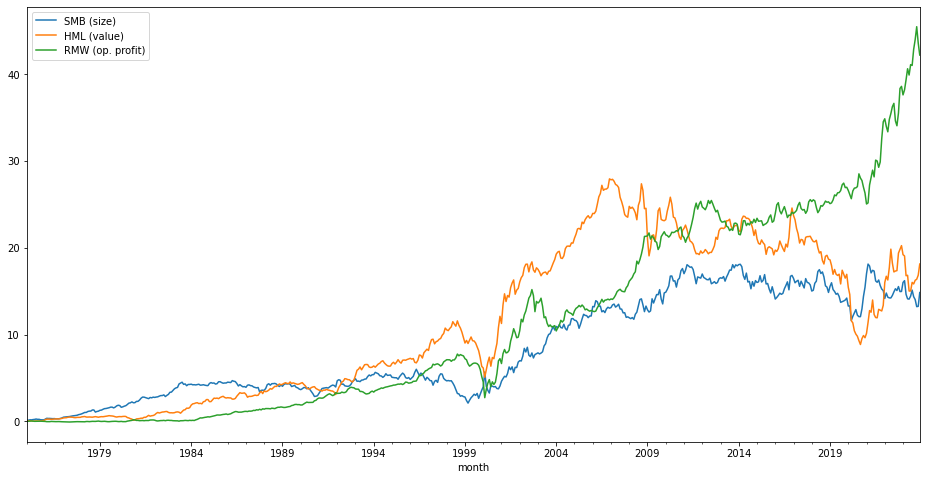

In [13]:
FF3Fb = FF3F['1975':'2023']
((1+FF3Fb['rf']+FF3Fb['smb']).cumprod() - (1+FF3Fb['rf']).cumprod()).plot(legend=True,label="SMB (size)");
((1+FF3Fb['rf']+FF3Fb['hml']).cumprod() - (1+FF3Fb['rf']).cumprod()).plot(legend=True,label="HML (value)");
((1+FF3Fb['rf']+FF3Fb['rmw']).cumprod() - (1+FF3Fb['rf']).cumprod()).plot(legend=True,label="RMW (op. profit)");

Takeaways from the previous figure:

If we set aside momentum, the other three factors tell a clear story on their own. Up to about the financial crisis, all three delivered positive cumulative return. Since they are designed to have low correlation with the market and with each other, this means each one would have been a valuable strategy for an investor to pursue.

- Since about the time of the financial crisis (or even a little earlier for HML), all three factors suddenly become less impressive. SMB and RMW basically stagnated, while HML has actually been declining.
- Since the pandemic, things have only gotten worse for HML while RMW has suddenly taken off and delivered astonishing returns. As a result, there is a lot of renewed attention on strategies based on profitability or other measures of "quality".

The performance of RMW seems to vindicate the classic Benjamin Graham and Warren Buffett approach to stock selection. However, the careful measurement here shows that these patterns also come and go. Why did this strategy suddenly improve so much over the last five years? Why is it present in the first place, given that everyone in the market knows that profitable companies are good ones? Shouldn't the prices of those stocks rise to the point that the returns go away? Factor models give us a way to quantify these questions but cannot answer them.

<center><h1>Buffett's Alpha</h1></center>

Discussion of paper by Frazzini, Kabiller, and Pedersen

<center>
<img src="https://wgjm1986.github.io/Investments/Module%203/Week%2013%20-%20The%20profitability%20factor/Table%201.png" height="400px" width="800px" />
</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Module%203/Week%2013%20-%20The%20profitability%20factor/Figure%201.png" height="400px" width="800px" />
</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Module%203/Week%2013%20-%20The%20profitability%20factor/optimal.png" height="400px" width="800px" />
</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Module%203/Week%2013%20-%20The%20profitability%20factor/Table%204.png" height="500px" width="500px" />
</center>

<center>
<img src="https://wgjm1986.github.io/Investments/Module%203/Week%2013%20-%20The%20profitability%20factor/Figure%203B.png" height="600px" width="600px" />
</center>